In [7]:
import pathlib
from pathlib import Path
import sys


In [8]:
# Cell 2 — Paths & sanity
PROJECT_ROOT = Path.cwd().parent
DATASET_DIR  = Path(r"C:\Users\YehonatanR\OneDrive - Holon Institute of Technology\Samsung\dataset")

clean_dir = DATASET_DIR / "clean"
new_dir   = DATASET_DIR / "new"
ref_dir   = DATASET_DIR / "ref"
test_json = DATASET_DIR / "test_metadata.json"

for p, name in [(DATASET_DIR,"DATASET_DIR"), (clean_dir,"clean"), (new_dir,"new"), (ref_dir,"ref"), (test_json,"test_metadata.json")]:
    if not p.exists():
        raise FileNotFoundError(f"Missing {name}: {p}")

print("OK — dataset found at:", DATASET_DIR)


OK — dataset found at: C:\Users\YehonatanR\OneDrive - Holon Institute of Technology\Samsung\dataset


In [9]:
# Cell 3 — Load PairedImageDataset
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import importlib
import PairedImageDataset
importlib.reload(PairedImageDataset)

from PairedImageDataset import PairedImageDataset


In [10]:
# Cell 4 — Load checkpoint, build PatchNetDual with orig/mixed/delta names, load norms

import torch
import torch.nn as nn
from pathlib import Path

CKPT_PATH = Path(r"C:\Users\YehonatanR\OneDrive\Documents\HIT Computer Science\3rd\PixelQuality\PythonProject\artifacts\locjnd_cls.pt")
ckpt = torch.load(CKPT_PATH, map_location="cpu")

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
    def forward(self, x): return self.net(x)

class TinyBranch(nn.Module):
    def __init__(self, in_ch, base):
        super().__init__()
        self.b1 = ConvBlock(in_ch, base)
        self.b2 = ConvBlock(base, base*2)  # -> 2*base channels
    def forward(self, x): return self.b2(self.b1(x))

class PatchNetDual(nn.Module):
    def __init__(self, num_classes=3, base=16, drop=0.3):
        super().__init__()
        # IMPORTANT: match checkpoint attribute names
        self.orig  = TinyBranch(3, base)        # 2*base ch
        self.mixed = TinyBranch(3, base)        # 2*base ch
        self.delta = TinyBranch(3, base//2)     # 2*(base//2)=base ch

        f_o = (base*2)       * 5 * 5           # 800 when base=16
        f_m = (base*2)       * 5 * 5           # 800
        f_d = ((base//2)*2)  * 5 * 5           # base*25 = 400
        feat = f_o + f_m + f_d                  # 2000

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 256), nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(256, num_classes),
        )

    def forward(self, o, m, d):
        fo = self.orig(o)
        fm = self.mixed(m)
        fd = self.delta(d)
        x = torch.cat([fo, fm, fd], dim=1)
        return self.head(x)

arch_params = ckpt.get("arch_params", {"num_classes":3, "base":16, "drop":0.3})
model = PatchNetDual(**arch_params)

state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
# with matching names, strict load should pass
model.load_state_dict(state_dict, strict=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
model.eval()

# per-stream normalization from training
norm = ckpt["norm"]
MEAN_O, STD_O = norm["mean_o"].numpy(), norm["std_o"].numpy()
MEAN_M, STD_M = norm["mean_m"].numpy(), norm["std_m"].numpy()
MEAN_D, STD_D = norm["mean_d"].numpy(), norm["std_d"].numpy()


In [11]:
# Cell 5 — Collate: sync pair, Δ=|m−o|, per-stream normalize using ckpt tensors

import numpy as np
from albumentations import Compose

SCORE_TO_LABEL = {0.0: 0, 0.5: 1, 1.0: 2}

# use the tensors saved in ckpt (from Cell 4)
MEAN_O_T = norm["mean_o"].view(3,1,1)
STD_O_T  = norm["std_o"].view(3,1,1)
MEAN_M_T = norm["mean_m"].view(3,1,1)
STD_M_T  = norm["std_m"].view(3,1,1)
MEAN_D_T = norm["mean_d"].view(3,1,1)
STD_D_T  = norm["std_d"].view(3,1,1)

aug = Compose([], additional_targets={'image_other': 'image'})  # no aug in eval

def _pil_to_chw_tensor(img):
    x = np.asarray(img.convert("RGB"), dtype=np.float32) / 255.0  # HWC [0,1]
    return torch.from_numpy(x).permute(2,0,1).contiguous()        # CHW

def collate_eval(batch):
    O, M, D, Y = [], [], [], []
    for clean_pil, other_pil, score in batch:
        o = _pil_to_chw_tensor(clean_pil)   # [3,H,W], float32
        m = _pil_to_chw_tensor(other_pil)

        # optional synced aug kept empty for test
        # if you add Resize via cv2/albumentations, apply BEFORE tensor conversion

        d = (m - o).abs()

        # per-stream normalize in torch with ckpt stats
        o = (o - MEAN_O_T) / (STD_O_T + 1e-12)
        m = (m - MEAN_M_T) / (STD_M_T + 1e-12)
        d = (d - MEAN_D_T) / (STD_D_T + 1e-12)

        O.append(o); M.append(m); D.append(d)
        Y.append(SCORE_TO_LABEL[float(score)])

    return torch.stack(O,0), torch.stack(M,0), torch.stack(D,0), torch.tensor(Y, dtype=torch.long)


In [12]:
# Cell 6 — Samsung test dataset + DataLoader

from torch.utils.data import DataLoader
from PairedImageDataset import PairedImageDataset
from pathlib import Path
import json
from collections import Counter

DATASET_DIR = Path(r"C:\Users\YehonatanR\OneDrive - Holon Institute of Technology\Samsung\dataset")
test_json   = DATASET_DIR / "test_metadata.json"

test_ds = PairedImageDataset(
    root_dir=str(DATASET_DIR),
    metadata_json_path=str(test_json),
    preload=False,
    device="cpu",
    transform=None,   # handled in collate
)

BATCH = 256
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH, shuffle=False,
    num_workers=0, pin_memory=True, collate_fn=collate_eval
)

# quick sanity
O, M, D, y = next(iter(test_loader))
print("Shapes:", O.shape, M.shape, D.shape, y.shape)

# fast class balance from JSON
with open(test_json, "r", encoding="utf-8") as f:
    meta = json.load(f)
counts = Counter(SCORE_TO_LABEL[float(it["score"])] for it in meta)
print("Class balance:", dict(sorted(counts.items())))


Shapes: torch.Size([256, 3, 20, 20]) torch.Size([256, 3, 20, 20]) torch.Size([256, 3, 20, 20]) torch.Size([256])
Class balance: {0: 389, 1: 127, 2: 224}


Pred distribution: {0: 326, 1: 68, 2: 346}


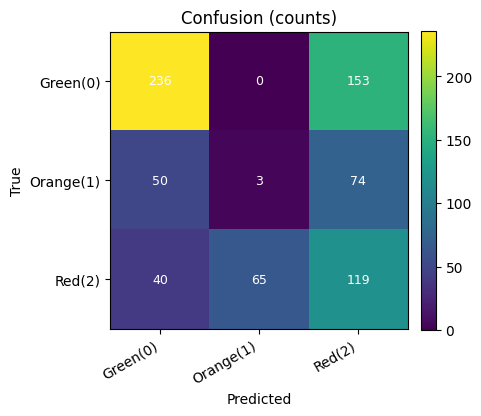

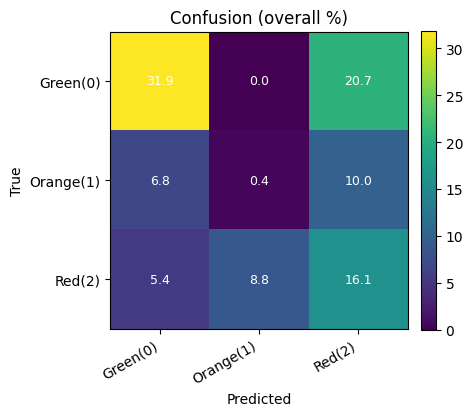

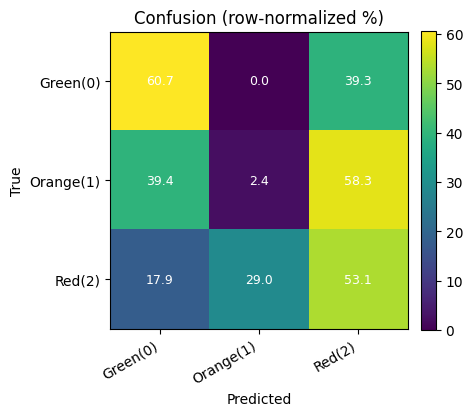

       class  accuracy_pct  support
0   Green(0)         60.67      389
1  Orange(1)          2.36      127
2     Red(2)         53.12      224
              precision    recall  f1-score   support

    Green(0)       0.72      0.61      0.66       389
   Orange(1)       0.04      0.02      0.03       127
      Red(2)       0.34      0.53      0.42       224

    accuracy                           0.48       740
   macro avg       0.37      0.39      0.37       740
weighted avg       0.49      0.48      0.48       740



In [13]:
# Cell 7 — Full evaluation: confusion matrices + per-class report

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval(); y_true, y_pred, probs = [], [], []
with torch.no_grad():
    for O, M, D, y in test_loader:
        O = O.to(DEVICE).float(); M = M.to(DEVICE).float(); D = D.to(DEVICE).float()
        x = {"O":O, "M":M, "D":D}
        a,b,c = "DOM"  # fixed order
        logits = model(x[a], x[b], x[c])
        p = torch.softmax(logits, dim=1).cpu().numpy()
        y_true.extend(y.numpy().tolist())
        y_pred.extend(p.argmax(1).tolist())
        probs.extend(p.tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred); probs = np.array(probs)
labels = [0,1,2]; names = ["Green(0)", "Orange(1)", "Red(2)"]

cm_abs = confusion_matrix(y_true, y_pred, labels=labels)
cm_all = confusion_matrix(y_true, y_pred, labels=labels, normalize='all')
cm_row = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

print("Pred distribution:", pd.Series(y_pred).value_counts().sort_index().to_dict())

def draw_cm(mat, title, is_percent=False):
    fig, ax = plt.subplots(figsize=(4.2,4.0))
    im = ax.imshow(mat if not is_percent else mat*100.0, cmap="viridis")
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(names, rotation=30, ha='right')
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i,j] * (100 if is_percent else 1)
            ax.text(j,i, f"{val:.1f}" if is_percent else f"{int(val)}",
                    ha='center', va='center', color="w", fontsize=9)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

draw_cm(cm_abs, "Confusion (counts)")
draw_cm(cm_all, "Confusion (overall %)", True)
draw_cm(cm_row, "Confusion (row-normalized %)", True)

# per-class summary
per_class_acc = np.diag(cm_row) * 100.0
summary = pd.DataFrame({
    "class": names,
    "accuracy_pct": per_class_acc.round(2),
    "support": [(y_true==i).sum() for i in labels]
})
print(summary)
print(classification_report(y_true, y_pred, labels=labels, target_names=names))
